[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 174
    # variables        = 1
    chi-square         = 1374.83803
    reduced chi-square = 7.94704065
    Akaike info crit   = 361.664248
    Bayesian info crit = 364.823304
[[Variables]]
    Ri0:   200 (fixed)
    Sui0:  250 (fixed)
    Fi0:   0 (fixed)
    k0:    2.6794e-05 +/- 1.5740e-07 (0.59%) (init = 2e-05)


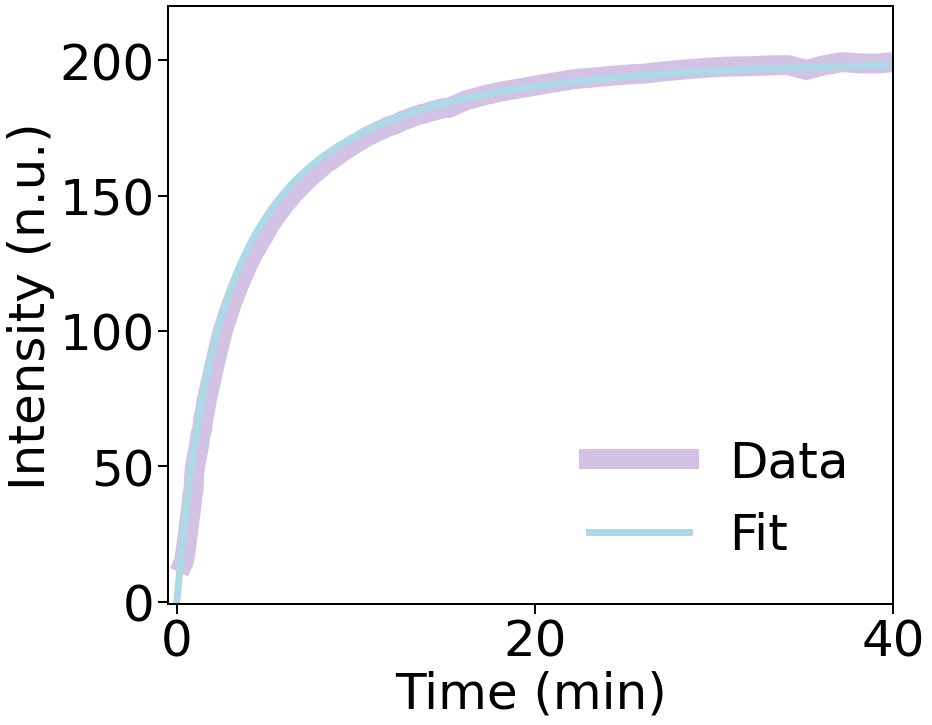

In [5]:
import numpy as np
import xlrd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

plt.rcParams['figure.figsize'] = 13, 11
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 2

file_location1 ="Drops-withRP.xls"
workbook1 = xlrd.open_workbook(file_location1)
first_sheet1 = workbook1.sheet_by_index(0)

time = [first_sheet1.cell_value(i, 0)+20 for i in range(1,175)]
F1 = [first_sheet1.cell_value(i, 1) for i in range(1,175)]


def f(y, t, paras):
    Ri = y[0]
    Sui = y[1]
    Fi = y[2]

    try:
        k0 = paras['k0'].value

    except KeyError:
        k0 = paras
    # the model equations
    f0 = -k0*Ri*Sui
    f1 = f0
    f2 = -f0
    return [f0, f1, f2]

time=np.array(time)
def g(t, x0, paras):
    x = odeint(f, x0, t, args=(paras,))
    return x


def residual(paras, t, data):
    x0 = paras['Ri0'].value, paras['Sui0'].value, paras['Fi0'].value
    model = g(t, x0, paras)
    Fi_model = model[:, 2]
    return (Fi_model[0:] - data[:175]).ravel()


# initial conditions
Ri0 = 200
Sui0 = 250
Fi0 = 0
y0 = [Ri0, Sui0, Fi0]

# measured data
t_measured = np.array(time)
Fi1_measured = np.array(F1)



def smooth(F1, box_pts):
    box = np.ones(box_pts)/box_pts
    F1_smooth = np.convolve(F1, box, mode='same')
    return F1_smooth




# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('Ri0', value=Ri0, vary=False)
params.add('Sui0', value=Sui0, vary=False)
params.add('Fi0', value=Fi0, vary=False)
params.add('k0', value=0.00002, min=0.00000001, max=0.0003044)
#params.add('k0', value=0.00015, vary=False)

# fit model
result1 = minimize(residual, params, args=(t_measured, Fi1_measured), method='leastsq')  # leastsq nelder
data_fitted_1 = g(np.linspace(0, max(t_measured), 190), y0, result1.params)



# plot fitted data
plt.plot(time[::1]/60, F1[::1], color='tab:purple', linewidth=20, linestyle='-', label='Data', alpha=0.4)
plt.plot(np.linspace(0,max(t_measured)/60, 190), data_fitted_1[:, 2], '-', linewidth=7, color='lightblue', label='Fit')
plt.legend(fontsize=50, frameon = False, loc=4)
plt.xlabel('Time (min)', fontsize=50)
plt.ylabel('Intensity (n.u.)', fontsize=50)
plt.axis([-0.5,40, -1, 220])
plt.tick_params(axis='both', length=10, width=2)
#plt.savefig("/mnt/c/Users/Thomas/Dropbox/TMSD in Random Pool/Vortrag/Random32.svg",dpi=900,format="svg")
# display fitted statistic
report_fit(result1)